เราสามารถประยุกต์ใช้ Callback ทำงานได้หลากหลาย เนื่องจากเราจะรู้ถึง Event ต่าง ๆ ที่เกิดขึ้นภายใน Training Loop ทุกขั้นตอน และ สามารถเข้าถึงข้อมูล Model, Runner, DataBunch, Loss Function, etc. ได้ทั้งหมด 

เรามาดู[ตัวอย่างการเขียน Callback ทำงานต่าง ๆ เช่น คำนวน Metrics, ย้ายข้อมูลขึ้น CUDA, Learning Rate Annealing, etc. เริ่มที่หัวข้อ 6](#6.-Callbacks)

แต่ Callback ก็มีข้อจำกัดอยู่ คือ เราไม่สามารถเข้าถึง Layer ต่าง ๆ หรือ Event ภายในโมเดลได้ เนื่องจากโมเดลที่เราใช้เป็นการเรียกใช้ API ของ PyTorch อีกต่อหนึ่ง ในกรณีที่เราต้องการเข้าถึงภายในโมเดล PyTorch ก็มี Callback ให้เราใช้เหมือนกัน เรียกว่า Hook จะอธิบายต่อไป

# 0. Magic

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [0]:
import torch
from torch import tensor
from torch.nn import *
import torch.nn.functional as F
from torch.utils.data import *
from fastai import datasets
from fastai.metrics import accuracy
import pickle, gzip, math, torch, re
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

# 2. Data

In [0]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
def normalize(x, m, s): 
    return (x-m)/s

In [0]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()   

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
nh, bs = 100, 32
n, m = x_train.shape
c = (y_train.max()+1).numpy()
loss_func = F.cross_entropy

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

# 3. DataBunch

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
data = DataBunch(train_dl, valid_dl, c)

# 4. Model

In [0]:
lr = 0.03
epoch = 10
nh = 50

In [0]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = Sequential(Linear(m, nh), ReLU(), Linear(nh,c))
    return model, loss_func

In [0]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data


# 5. Training Loop

Training Loop ที่รองรับ Callback

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs

    @property
    def opt(self):          return self.learn.opt
    @property
    def model(self):        return self.learn.model
    @property
    def loss_func(self):    return self.learn.loss_func
    @property
    def data(self):         return self.learn.data

    def one_batch(self, xb, yb):
        try: 
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
    
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl:
                self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
    
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.train = None

    def __call__(self, cb_name):
        # return True = Cancel, return False = Continue (Default)
        res = False
        # check if at least one True return True
        for cb in sorted(self.cbs, key=lambda x: x._order): res = res or cb(cb_name)
        return res        

In [0]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
    
    def begin_epoch(self):
        self.run.n_epochs = self.epoch  
        self.model.train()
        self.run.in_train=True

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False    
           
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

# 6. Callbacks

## 6.1 Recorder Callback

เริ่มกันที่ Recorder Callback เป็น Callback ที่ทำหน้าที่เก็บ Loss และ Learning Rate ของแต่ละ Batch (after_batch) เอาไว้พล็อตกราฟ ใน ep หน้า เราจะเห็นการเปลี่ยนแปลงของ Learning Rate ในช่วงต่าง ๆ ของการเทรน เป็นการทำ Learning Rate Annealing จะอธิบายต่อไป

In [0]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

ลองเทรน แล้วพล็อตกราฟ

In [0]:
model, loss_func = get_model()
opt = torch.optim.SGD(model.parameters(), lr=lr)
learn = Learner(model, opt, loss_func, data)

run = Runner(cb_funcs=Recorder)
run.fit(2, learn)

เราสามารถสั่งพล็อตกราฟ จาก Recorder Callback ได้ดังด้านล่าง

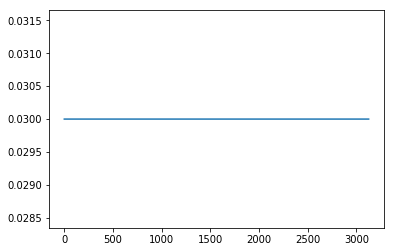

In [26]:
run.recorder.plot_lr()

สังเกตว่า Learning Rate คงที่ตลอด, Loss ลดลงอย่างรวดเร็ว แต่กราฟเหวี่ยงมาก เนื่องจาก [SGD Algorithm](https://www.bualabs.com/archives/631/what-is-gradient-descent-in-deep-learning-what-is-stochastic-gradient-descent-sgd-optimization-ep-1/)

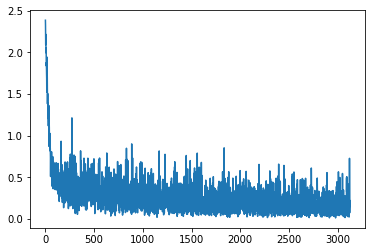

In [27]:
run.recorder.plot_loss()

## 6.2 AvgStatsCallback

ต่อกันที่ AvgStatsCallback เราจะเขียน Callback ที่จะทำหน้าที่คำนวน Metrics หลังจากที่คำนวน Loss ทุกครั้ง (after_loss) สะสมไว้ แล้วหาค่าเฉลี่ย ตอนจบ Epoch (after_epoch) แล้ว Print ออกมา

In [0]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

สร้าง Class ที่เป็น Logic คำนวน

In [0]:
class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn


ลองเทส AvgStatsCallback โดยใช้ Metric ตัวเดียว ในที่นี้คือ accuracy 

In [0]:
model, loss_func = get_model()
opt = torch.optim.SGD(model.parameters(), lr=lr)
learn = Learner(model, opt, loss_func, data)

In [31]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)
run.fit(5, learn)

train: [0.34270421875, tensor(0.9034)]
valid: [0.2095277099609375, tensor(0.9426)]
train: [0.181161953125, tensor(0.9478)]
valid: [0.15168736572265626, tensor(0.9576)]
train: [0.13492318359375, tensor(0.9614)]
valid: [0.128795068359375, tensor(0.9638)]
train: [0.110105986328125, tensor(0.9689)]
valid: [0.1172744384765625, tensor(0.9667)]
train: [0.09379328125, tensor(0.9730)]
valid: [0.11024613037109375, tensor(0.9678)]


In [32]:
loss, acc = stats.valid_stats.avg_stats
loss, acc

(0.11024613037109375, tensor(0.9678))

## 6.3 ใช้ Partial ช่วยสร้าง Callback

In [0]:
from functools import partial

ถ้าเราใช้ ลองเทส AvgStatsCallback โดยใช้แค่ accuracy บ่อย ๆ เราสามารถใช้ Partial สร้าง Function/Class ใหม่จาก AvgStatsCallback + Accuracy เตรียมไว้ได้เลย

In [0]:
acc_cbf = partial(AvgStatsCallback, accuracy)

ลองเทรนโมเดล โดยพาส Callback ใหม่ที่สร้างจาก Partial และ Recorder ทั้ง 2 Callback ใส่ List ไปให้ cb_funcs=[acc_cbf, Recorder] 

In [35]:
model, loss_func = get_model()
opt = torch.optim.SGD(model.parameters(), lr=lr)
learn = Learner(model, opt, loss_func, data)

run = Runner(cb_funcs=[acc_cbf, Recorder])
run.fit(5, learn)

train: [0.3383512890625, tensor(0.9057)]
valid: [0.206078076171875, tensor(0.9431)]
train: [0.1765188671875, tensor(0.9477)]
valid: [0.152457568359375, tensor(0.9583)]
train: [0.130566201171875, tensor(0.9617)]
valid: [0.13066519775390625, tensor(0.9641)]
train: [0.105532783203125, tensor(0.9688)]
valid: [0.11904864501953125, tensor(0.9660)]
train: [0.089093916015625, tensor(0.9739)]
valid: [0.1128606201171875, tensor(0.9674)]


acc_cbf Callback ก็จะ Print Training Loss+Accuracy และ Validation Loss+Accuracy และเราสามารถสั่งพล็อตกราฟ จาก Recorder Callback ได้ดังด้านล่าง

In [36]:
run.avg_stats.valid_stats.avg_stats

[0.1128606201171875, tensor(0.9674)]

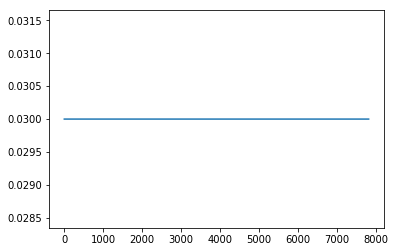

In [38]:
run.recorder.plot_lr()

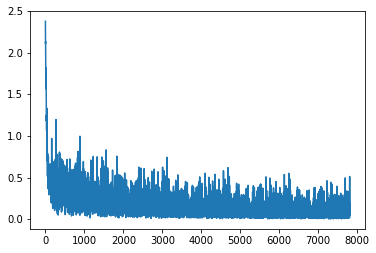

In [39]:
run.recorder.plot_loss()

# Credit

* https://course.fast.ai/videos/?lesson=9
* http://yann.lecun.com/exdb/mnist/